In [1]:
import os

os.chdir("../../test_data/system_tests/quicktests/quicktest_spectronaut_largefc")

In [2]:
INPUT_FILE = "20210210_154121_S209-S-1-240min_Report_quicktest_shortened.tsv"
HOUSEKEEPING_PROTEINS = "housekeeping_proteins.tsv"
SAMPLEMAP = "samplemap.tsv"
RESULTS_DIR = "results"

/Users/constantin/workspace/alphabase/alphabase/quantification/quant_reader/config_dict_loader.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  uploaded_data_columns = set(pd.read_csv(input_file, sep=sep, nrows=1, encoding ='latin1').columns)
/Users/constantin/workspace/alphabase/alphabase/quantification/quant_reader/config_dict_loader.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  uploaded_data_columns = set(pd.read_csv(input_file, sep=sep, nrows=1, encoding ='latin1').columns)
/Users/constantin/workspace/alphabase/alphabase/quantification/quant_reader/longformat_reader.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespa

using input type spectronaut_fragion_isotopes


/Users/constantin/workspace/alphabase/alphabase/quantification/quant_reader/config_dict_loader.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  uploaded_data_columns = set(pd.read_csv(input_file, sep=sep, nrows=1, encoding ='latin1').columns)


removed pre existing /Users/constantin/workspace/alphaquant/test_data/system_tests/quicktests/quicktest_spectronaut_largefc/20210210_154121_S209-S-1-240min_Report_quicktest_shortened.tsv.ml_info_table.tsv
start processeing condpair ('S1', 'S2')
normalized within conditions
without missingvals (if applicable)


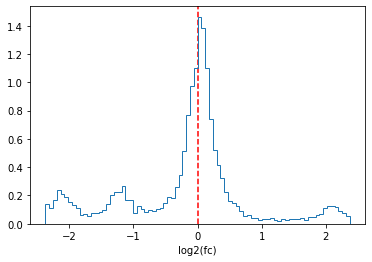

complete dataset


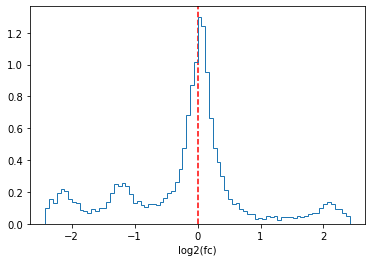

shift comparison by -0.04971475586159446


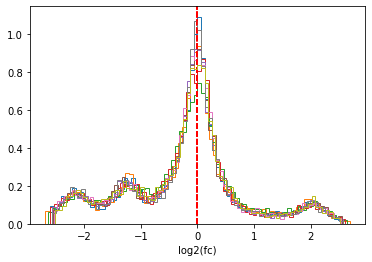

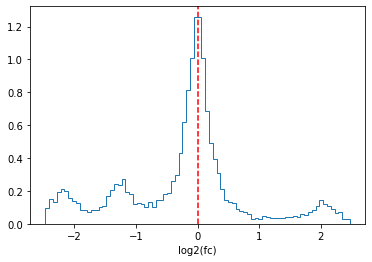

normalized between conditions
t_ion2nonan_sw 0.03485703468322754
t_intensity_selection 0.37892603874206543
t_ion2nonan_sw 0.039808034896850586
t_intensity_selection 0.4443790912628174
checked 0 of 11487 ions
checked 2000 of 11487 ions
checked 4000 of 11487 ions
checked 6000 of 11487 ions
checked 8000 of 11487 ions
checked 10000 of 11487 ions
checked 0 of 66 prots


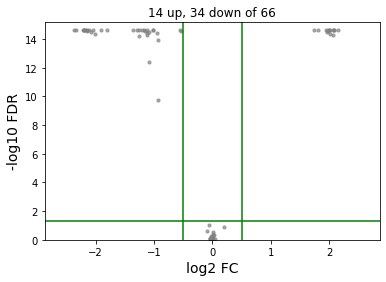

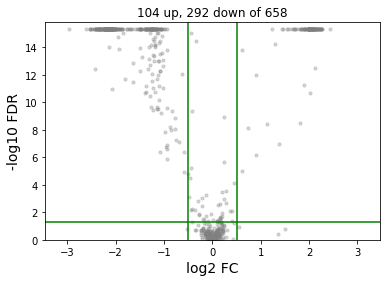


condition pair ('S1', 'S2') finished!



In [3]:
import alphaquant.run_pipeline as run_pipeline

run_pipeline.run_pipeline(input_file=INPUT_FILE, samplemap_file=SAMPLEMAP, results_dir=RESULTS_DIR, runtime_plots=True, protein_subset_for_normalization_file=HOUSEKEEPING_PROTEINS, 
                           annotation_columns=["PG.Genes", "PG.Organisms"])

In [4]:
import pandas as pd
resuls_table = f"{RESULTS_DIR}/S1_VS_S2.results.tsv"

results_df = pd.read_csv(resuls_table, sep="\t")


results_df_reformat = results_df[["protein", "PG.Organisms", "log2fc", "fdr"]].rename(columns={"PG.Organisms": "organism","log2fc": "log2fc_alphaquant", 
                                                                                               "fdr": "fdr_alphaquant"})
display(results_df_reformat)

,protein,organism,log2fc_alphaquant,fdr_alphaquant
0,P0A7K2,Escherichia coli (strain K12),-2.367460,2.167969e-15
1,P62937,Homo sapiens,0.014113,9.315486e-01
2,P22768,Saccharomyces cerevisiae (strain ATCC 204508 /...,1.968355,3.085251e-15
3,Q14103;Q14103-3,Homo sapiens,-0.023369,5.397566e-01
4,Q19289,Caenorhabditis elegans,-1.116034,3.567800e-15
...,...,...,...,...
61,P39936,Saccharomyces cerevisiae (strain ATCC 204508 /...,-0.043199,8.931095e-01
62,P0A6E6,Escherichia coli (strain K12),-2.200027,2.167969e-15
63,Q04409,Saccharomyces cerevisiae (strain ATCC 204508 /...,0.018641,5.035345e-01
64,Q9XX15,Caenorhabditis elegans,-0.935457,1.915661e-10


In [12]:
import numpy as np
import alphaquant.benchm.sensitivity_tests as aq_sensitivity_tests

classification_benchmark = aq_sensitivity_tests.RatioClassificationTableGenerator(results_df_reformat, decoy_organism="Homo sapiens", method_suffixes=["_alphaquant"])
classification_df = classification_benchmark.per_species_results_df.replace(np.nan, 0)
display(classification_df["organism"].to_list())




['Caenorhabditis elegans',
 'Escherichia coli (strain K12)',
 'Homo sapiens',
 'Saccharomyces cerevisiae (strain ATCC 204508 / S288c)']

In [16]:
def assert_fdr_is_not_violated(classification_df, suffix = "_alphaquant",  decoy_organism="Homo sapiens"):
    idx_of_decoy_organism = classification_df[classification_df["organism"] == decoy_organism].index
    num_allowed_hits = classification_df.loc[idx_of_decoy_organism, f"allowed_decoy_hits{suffix}"].values[0]
    num_allowed_hits_w_tolerance = int(1.1*num_allowed_hits)
    num_actual_hits =  classification_df.loc[idx_of_decoy_organism,f"hits{suffix}"].values[0]

    assert num_actual_hits < num_allowed_hits_w_tolerance , "more false postives than expected"


def assert_sensitivity_is_as_expected(classification_df):
    classification_df = classification_df.set_index("organism")
    assert classification_df.loc["Caenorhabditis elegans", "hits_alphaquant"] >=19
    assert classification_df.loc["Escherichia coli (strain K12)", "hits_alphaquant"] >=15
    assert classification_df.loc["Saccharomyces cerevisiae (strain ATCC 204508 / S288c)", "hits_alphaquant"] >=14


assert_fdr_is_not_violated(classification_df)
assert_sensitivity_is_as_expected(classification_df)